In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits import mplot3d
import datetime as dt

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/julienjta/Data-Science-Portfolio/main/Project%203/data/data.csv",encoding = 'unicode_escape')
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head(10)

There are 541909 observations for 8 predictors.


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
5  12/1/2010 8:26       7.65     17850.0  United Kingdom  
6  12/1/2010 8:26       4.25     17850.0  United Kingdom  
7  12/1/2010 8:28       1.85     17850.0  United Kingdom  
8  12/1/2010 8:28       1.85     17850.0  United Kingdom  
9  12/1/2010 8:34       1.69     13047.0  United Kingdom

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]

# 1. Cleaning the Data

Delete NaN rows

In [5]:
df[df.isin(["NaN","missing","?","??"]).any(axis=1)].shape[0]

56

I will get read of those rows that give no informations on the customers to identify or on the products bought.

In [6]:
df = df[df.isin(["NaN","missing","?","??"]).any(axis=1) == False]

In [7]:
df.shape

(516328, 8)

Deal with the description format

There are some inconsistencies in the data descriptions.

In [8]:
df["Description"].nunique()

4211

In [9]:
df["Description"].str.lower().str.strip().nunique()

4183

In [10]:
df["Description"] = df["Description"].str.lower().str.strip()

Dealing with non items

Some descriptions are just fees and not items. We can delete them.

In [11]:
df = df[df["Description"].isin(["amazon fee", "samples", "postage", "packing charge","manual","discount","adjust bad debt","bank charges","cruk commission","next day carriage"]) == False]

Delete null price and quantities

Some items have a quantity or a unit price equals to zero. We can delete those rows.

In [12]:
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]


Deal with data inconsistencies

I will check if the stock code is always linked to one description.

In [13]:
df["Description"].nunique()

4018

In [14]:
df["StockCode"].nunique()

3924

In [15]:
df.groupby("StockCode")["Description"].nunique().sort_values(ascending = False)

StockCode
23236           4
23196           4
23131           3
23413           3
23370           3
               ..
22419           1
22420           1
22421           1
22422           1
gift_0001_50    1
Name: Description, Length: 3924, dtype: int64

For the above:
The resulting output will be a Series that shows the counts of unique descriptions for each unique stock code, sorted in descending order. This information can be useful for identifying stock codes that have a wide variety of descriptions, potentially indicating different variations or versions of products.



It is the same product, but written in different ways. I will just keep the first description that appears.


In [16]:

for stack_code in df["StockCode"].unique():
    first_description = df[df["StockCode"]==stack_code]["Description"].unique()[0]
    df.loc[df["StockCode"]==stack_code, "Description"] = first_description

The purpose of the above code snippet seems to be to standardize the descriptions for each stock code by assigning the first unique description to all occurrences of that stock code. This can be useful for consolidating and aligning the descriptions associated with each stock code in the dataset.

Now we can check again the NaN values:

In [17]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     124510
Country             0
dtype: int64

Deal with outliers

<Axes: ylabel='TotalPrice'>

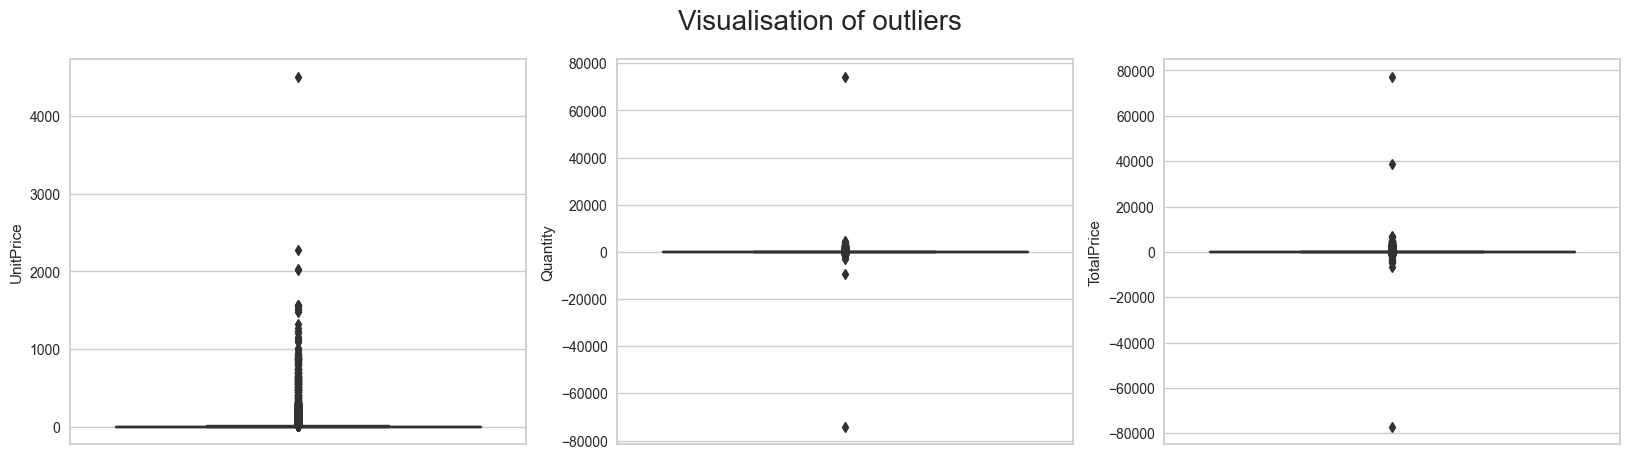

In [18]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

fig = plt.figure(figsize = (20,5))
fig.suptitle("Visualisation of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=df,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df,y="TotalPrice")

In [19]:
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]

By assigning the filtered DataFrame back to df, the resulting DataFrame will exclude any rows where the "TotalPrice" values are more than 3 standard deviations away from the mean. This operation helps in removing potential outliers or extreme values in the "TotalPrice" column, allowing for a more reliable analysis or modeling.

# 2. Exploratory Data Analysis

What is the general sales trend?

👇 To understand the general sales trend, I will plot the amount of money generated by the sales for each day through the studied period.

In [20]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)

☝️ Overall, this code calculates the total price for each date based on the quantity and unit price from the original DataFrame df. It then groups the data by date and sums up the total prices to obtain the general trend of total prices over time. The resulting general_trend DataFrame or Series (depending on the last step) contains the date and the corresponding total price for each date.

In [21]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]

☝️ After executing this code, the dates list will contain datetime objects representing the months from December 2010 to November 2011. The list will have a length of 12, with each datetime object representing a specific month within that range.

In [22]:
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean()

☝️ After executing these lines of code, the rolling_days DataFrame will contain the "Total price" column with the rolling average values calculated using a window size of 30 days. This rolling average can be useful for smoothing out short-term fluctuations and highlighting long-term trends in the total price data over time.

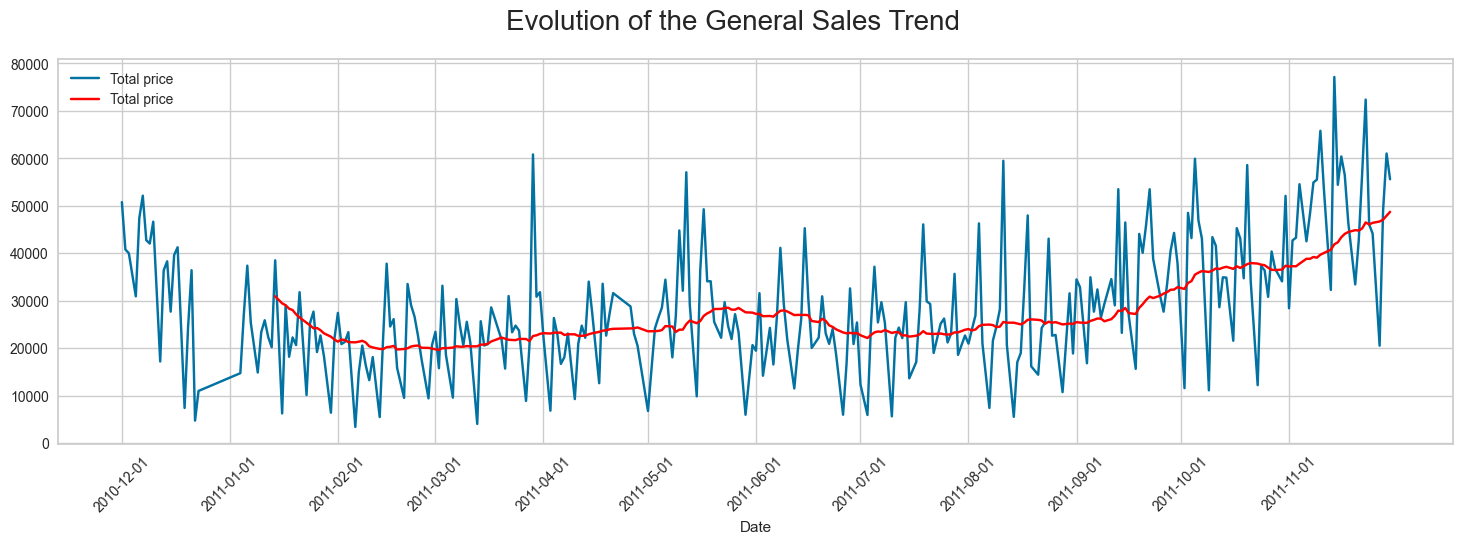

In [23]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

In [24]:
general_trend.index = pd.to_datetime(general_trend.index)
general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
general_trend_months = pd.DataFrame(general_trend_months)

In [25]:
general_trend_months

Total price
Date Date             
2010 12     678728.300
2011 1      530649.820
     2      482045.810
     3      643790.990
     4      475877.451
     5      694332.130
     6      620456.720
     7      621908.121
     8      654239.280
     9      902618.741
     10     965988.770
     11    1299220.630

In [26]:
general_trend_months["Date"] = dates

plt.figure(figsize = (20,10)).suptitle('General sales for each months', fontsize=25)
lineplot = sns.lineplot(data=general_trend_months,x="Date", y="Total price", marker="o",linewidth = 2)


lineplot.set_xlabel(xlabel="Date",size = 20)
lineplot.set_ylabel(ylabel="Total Price",size = 20)
plt.yticks(fontsize=12)
plt.xticks(dates,rotation = 45,fontsize=12)

plt.show()

What is an average cart by country?

In this part I will study the trends per countries to spot any differencies. First of all try to see if there are difference in the way customers frome each country buy products in term of quantities and prices.

In [27]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()

What is an average cart by country?¶


In this part I will study the trends per countries to spot any differencies. First of all try to see if there are difference in the way customers frome each country buy products in term of quantities and prices.

In [28]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()

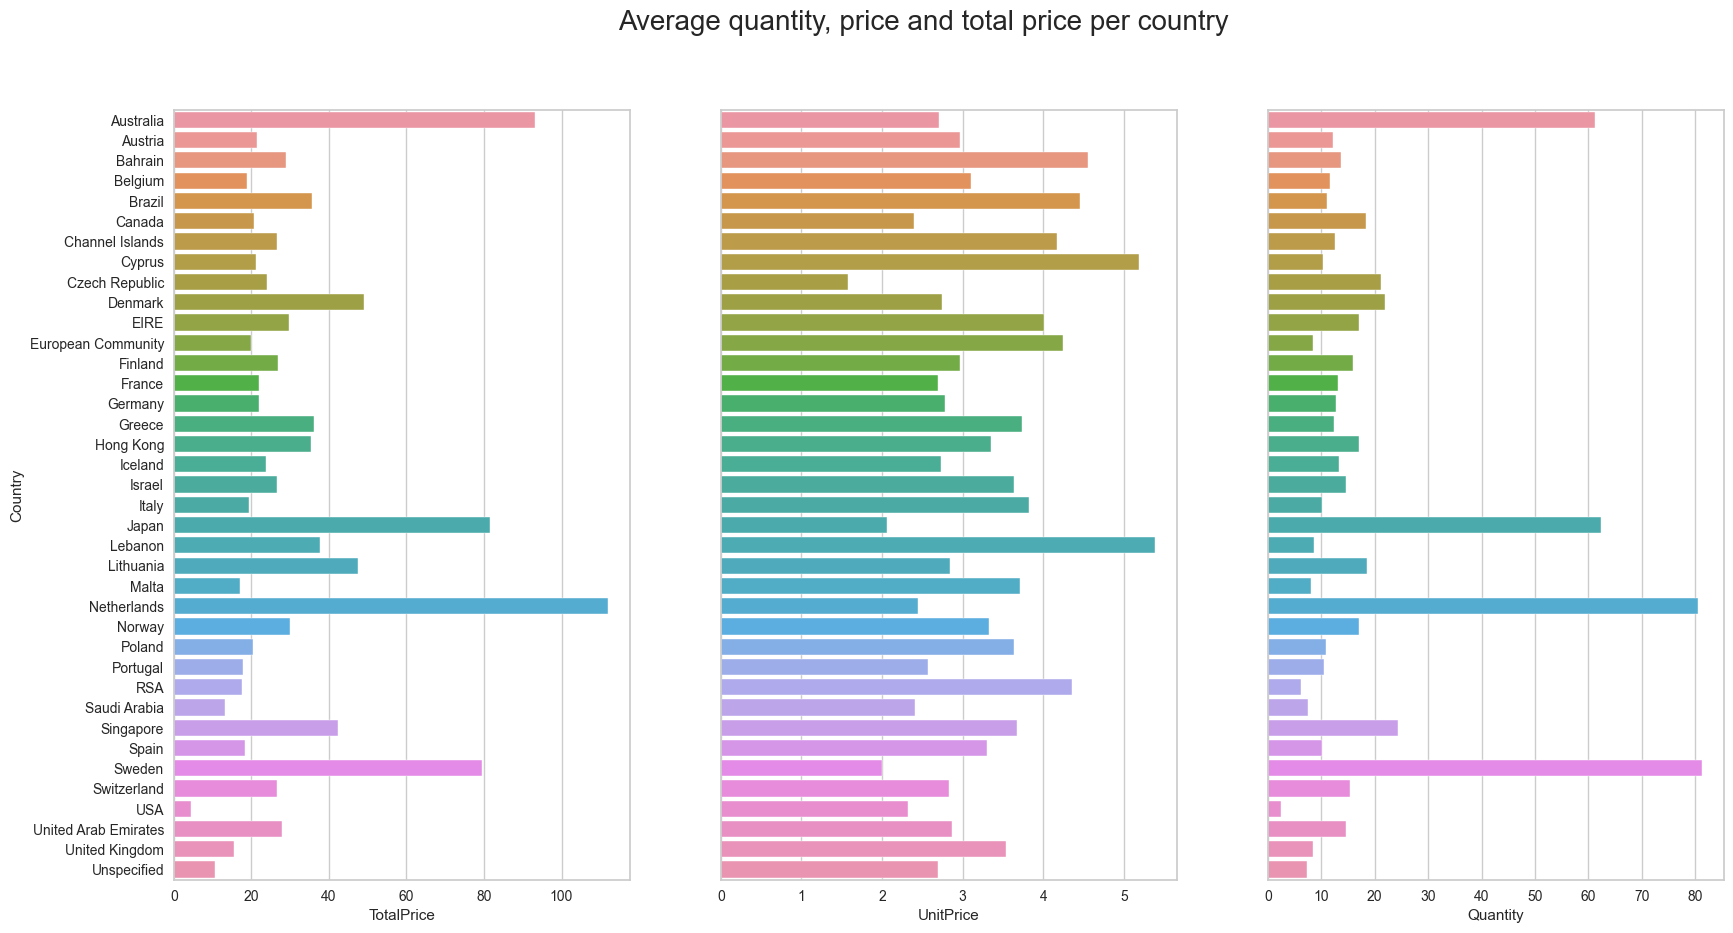

In [29]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=average_cart_countries,x="TotalPrice",y="Country")

axes = fig.add_subplot(1, 3, 2)
sns.barplot(data=average_price_countries,x="UnitPrice",y="Country")
fig.axes[1].get_yaxis().set_visible(False)

axes = fig.add_subplot(1, 3, 3)
sns.barplot(data=average_quantity_countries,x="Quantity",y="Country")
fig.axes[2].get_yaxis().set_visible(False)

In [30]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = average_cart_countries["Country"],
                  locationmode = "country names",
                  z = average_cart_countries["TotalPrice"].astype(float).round(0).tolist(),
                  hovertext = average_cart_countries["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 

layout = dict(
              title = "Average Total Price Per Cart By Country",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
iplot(fig)

📌 There are four countries that tend to buy have an average cart bigger than the others: the Netherlands, Australia, Japan and Sweden. Based on the plots for quantity and total prices, it seems that those countries have a bigger carts because of quantities, a customer from those countries will buy more quantities than in others.

Hong Kong and Singapore customers tend to be more attracted by expensive items.

What are the best selling products?

We can also exhibit what items are the best for each countries.

In [31]:
sum_total_price_products = pd.DataFrame(df.groupby(["Country","Description"])["TotalPrice"].sum())
best_selling_product = pd.DataFrame(data=sum_total_price_products.groupby(["Country"])['TotalPrice'].idxmax().values.tolist(),columns =['Country', 'Best Selling Product'])

max_sales = sum_total_price_products.groupby("Country")["TotalPrice"].max().values.tolist()
best_selling_product["Sales"] = max_sales

total_sales = sum_total_price_products.groupby("Country")["TotalPrice"].sum().values.tolist() 
best_selling_product["Country total sales"] = total_sales

best_selling_product["% of country sales"] = best_selling_product["Sales"]/best_selling_product["Country total sales"]

After executing this code, you will have a DataFrame best_selling_product that contains the best-selling product, total sales, and the percentage of country sales for each country. The DataFrame will have the following columns: "Country", "Best Selling Product", "Sales", "Country total sales", and "% of country sales".

In [32]:
best_selling_product \
.style.background_gradient(cmap=sns.light_palette("seagreen", as_cmap=True), \
 subset=["% of country sales"]) \
.format({"% of country sales":"{:.2%}",
         "Sales":"£{:,.0f}",
         "Country total sales":"£{:,.0f}"})

In [33]:
df.Description.value_counts()[:10]

white hanging heart t-light holder    2284
regency cakestand 3 tier              2097
jumbo bag red retrospot               2089
party bunting                         1671
lunch bag red retrospot               1595
assorted colour bird ornament         1451
set of 3 cake tins pantry design      1421
small popcorn holder                  1396
pack of 72 retrospot cake cases       1347
lunch bag suki  design                1314
Name: Description, dtype: int64

By executing this code, you will obtain the frequency count of each unique description in the DataFrame df and display the top 10 descriptions with their respective counts.

📌 The best selling product is the "white hanging heart T-light holder". The best selling items are different based on the countries.

How often do customers buy products?

In this part, I will study how often customers from the different countries buy items on the website.

In [34]:
count_transactions_per_country = df.groupby([df.Country,df.InvoiceDate]).Description.count().reset_index()
count_transactions_per_country = count_transactions_per_country.groupby([count_transactions_per_country.Country]).Description.sum()
count_transactions_per_country = pd.DataFrame(count_transactions_per_country)

In [35]:
unique_per_country = df.groupby([df.Country]).CustomerID.nunique()
unique_per_country = pd.DataFrame(unique_per_country)
unique_per_country = unique_per_country.drop("Hong Kong")

After executing this code, you will have a DataFrame count_transactions_per_country that contains the total count of transactions per country. The DataFrame will have the "Country" column and the corresponding count of transactions as the "Description" column.

After executing this code, you will have a DataFrame unique_per_country that contains the number of unique customers per country. The DataFrame will have the "Country" column and the corresponding count of unique customers as the "CustomerID" column. The row for "Hong Kong" will be excluded from the DataFrame.

In [36]:
transactions_per_customer_per_countries = pd.concat([count_transactions_per_country,unique_per_country],axis=1).reset_index()
transactions_per_customer_per_countries["Value"] = transactions_per_customer_per_countries["Description"]/transactions_per_customer_per_countries["CustomerID"]/12

After executing this code, you will have the transactions_per_customer_per_countries DataFrame, which contains the country, total transaction count (Description column), number of unique customers (CustomerID column), and the average number of transactions per customer per year (Value column).

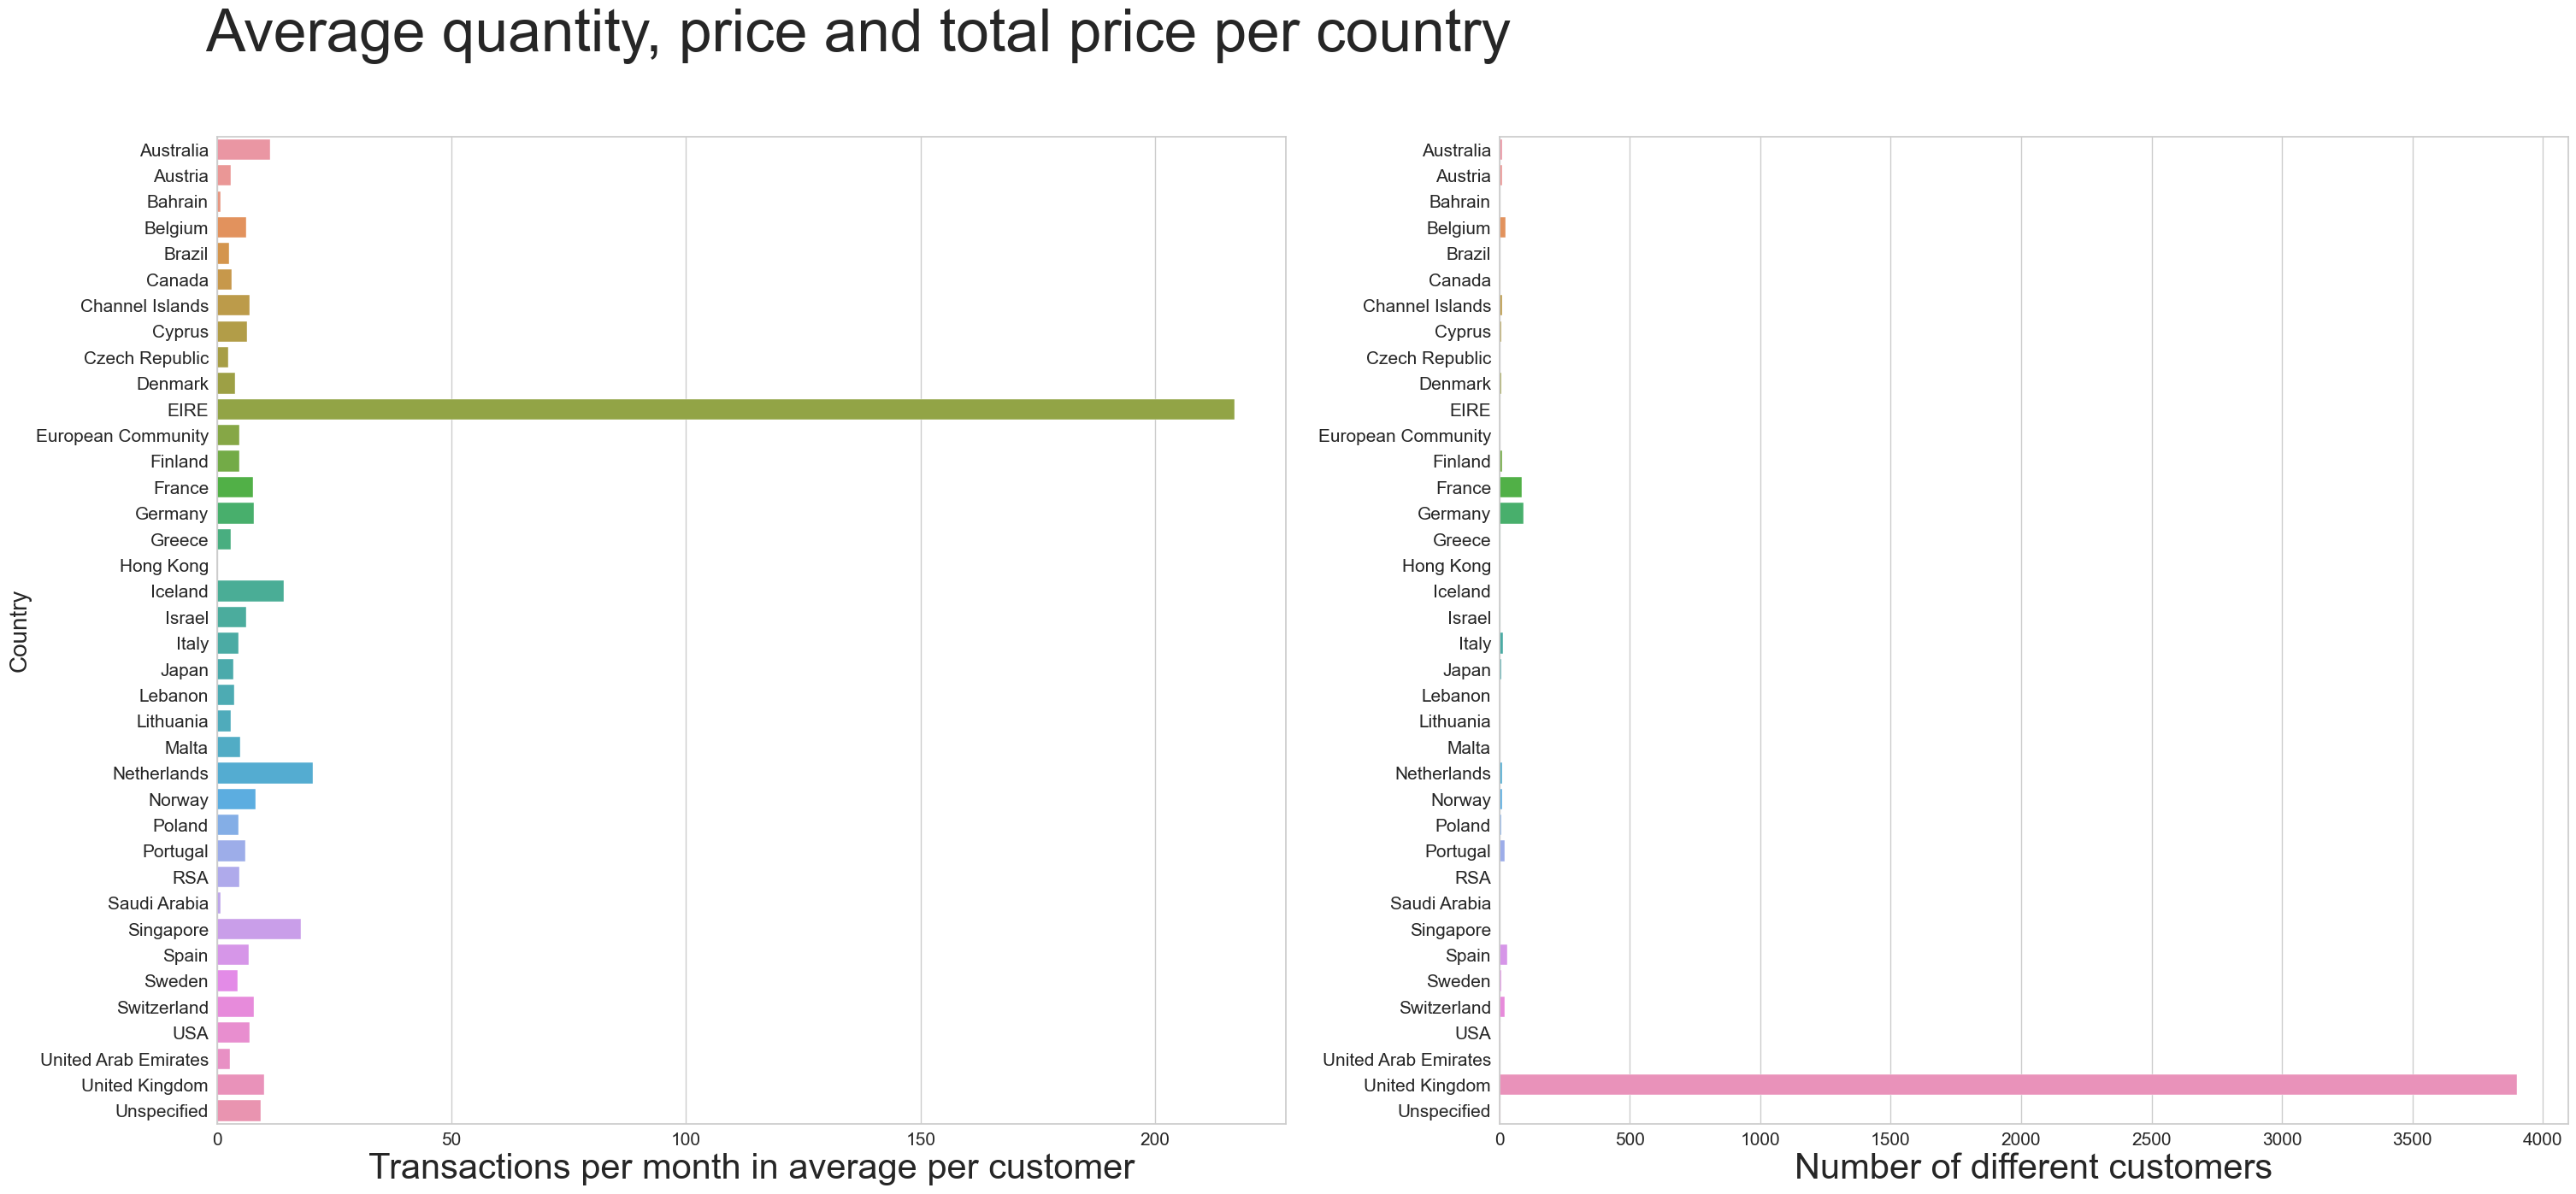

In [37]:
fig = plt.figure(figsize = (20,15))
fig.suptitle("Average quantity, price and total price per country",size=50)

axes = fig.add_subplot(1, 2, 1)
sns.barplot(data=transactions_per_customer_per_countries,x="Value",y="Country")
axes.set_xlabel('Transactions per month in average per customer',size = 30)
axes.set_ylabel('Country',size = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

axes = fig.add_subplot(1, 2, 2)
sns.barplot(data=transactions_per_customer_per_countries,x="CustomerID",y="Country")
axes.set_xlabel('Number of different customers',size = 30)
axes.set_ylabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.subplots_adjust(right=1.5)

plt.show()

In [38]:
transactions_per_customer_without_ireland = transactions_per_customer_per_countries[transactions_per_customer_per_countries.Country!="EIRE"]
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = transactions_per_customer_without_ireland["Country"],
                  locationmode = "country names",
                  z = transactions_per_customer_without_ireland["Value"].astype(float).round(0).tolist(),
                  hovertext = transactions_per_customer_without_ireland["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Transactions", },
                ) 



layout = dict(
              title = "Transactions Per Month In Average Per Customer Excluding Ireland",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
iplot(fig)

We can calculate the global average for the number of transaction per month per customers:

In [39]:
transactions_per_customer_per_countries.Description.sum()/transactions_per_customer_per_countries.CustomerID.sum()/12

9.851611908067254

📌 This graph highlights that in average, customers will make around 10 transactions per month. There is one big exception with Ireland, where there is an average of 225 transaction but this is linked to only three customers.

It is also visible that most of the customers comes from UK with almost 4,000 unique customers, then France and Germany far behind with around 100.

What countries are the most active?

In [40]:
general_trend_country = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate),
                                   'Country':df.Country,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend_country = general_trend_country.groupby([general_trend_country.Date.dt.to_period("M"),general_trend_country.Country]).sum()
general_trend_country = pd.DataFrame(general_trend_country).reset_index()

C:\Users\impra\AppData\Local\Temp\ipykernel_11308\742264918.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [41]:
general_trend_country.groupby([general_trend_country.Country]).sum().sort_values(by='Total price',ascending=False).head(10)

C:\Users\impra\AppData\Local\Temp\ipykernel_11308\828238582.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Total price
Country                    
United Kingdom  7207219.683
Netherlands      247908.660
EIRE             233058.520
Germany          191850.500
France           173482.940
Australia        114202.640
Switzerland       52505.350
Spain             43950.970
Belgium           35382.530
Sweden            34384.910

In [42]:


general_trend_country.Date = general_trend_country.Date.dt.to_timestamp()



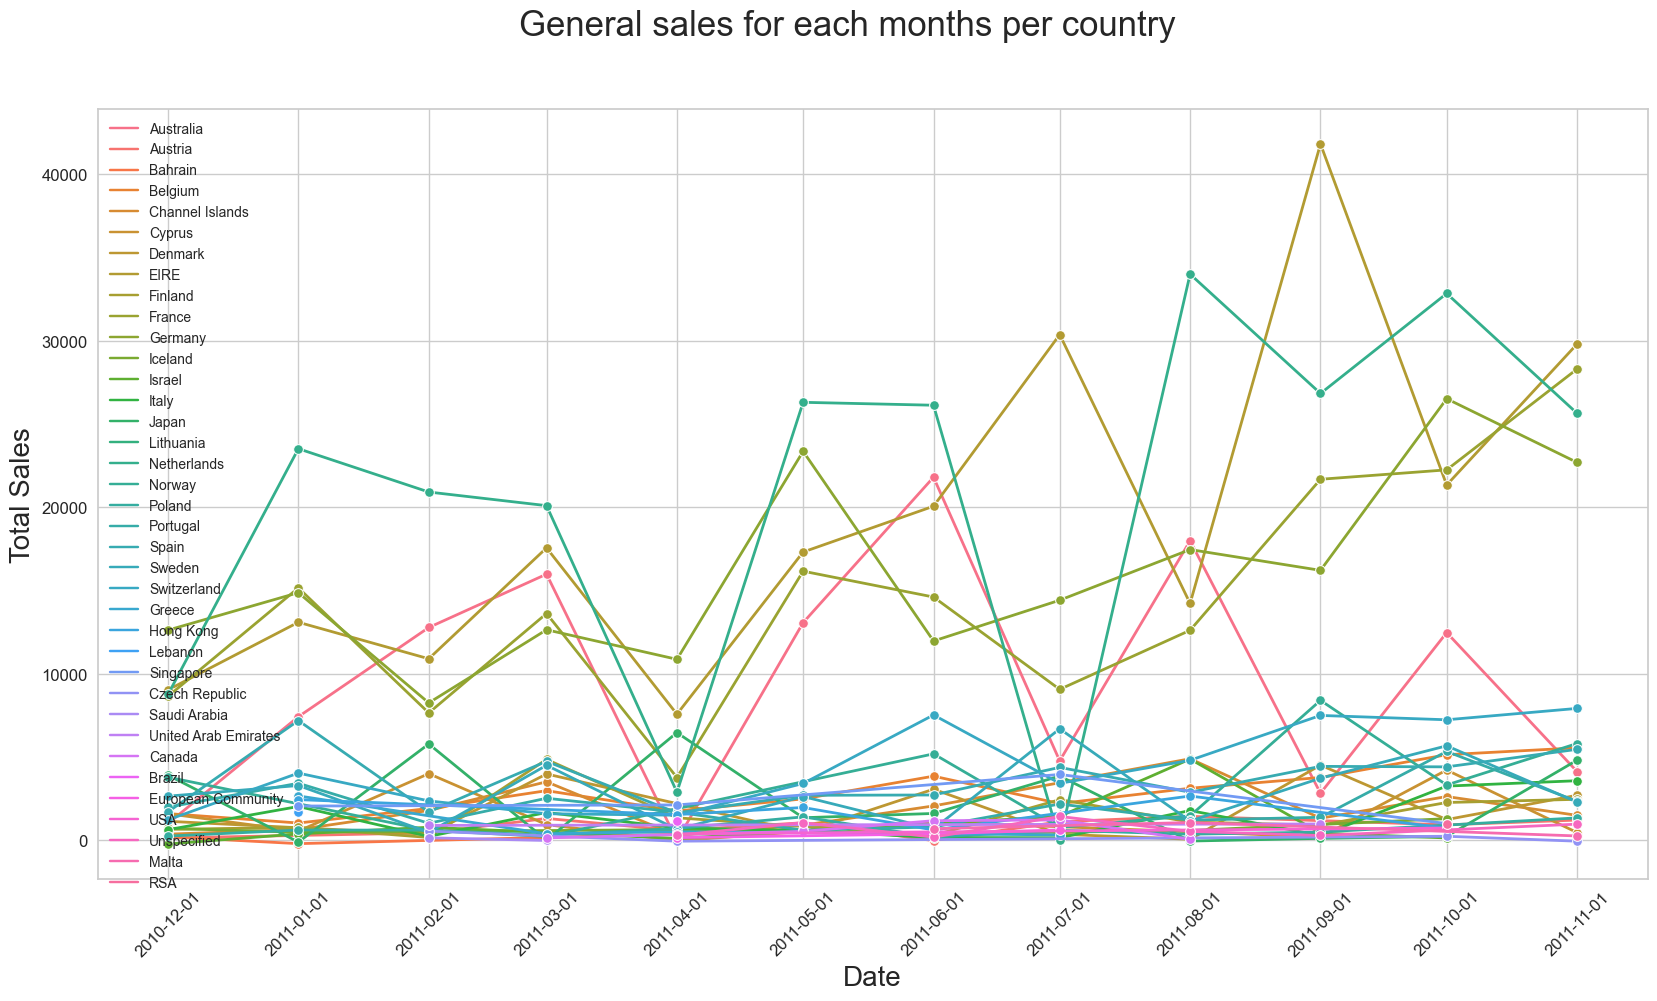

In [43]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months per country', fontsize=25)
lineplot = sns.lineplot(data=general_trend_country.loc[general_trend_country.Country!="United Kingdom"],x="Date", y="Total price",hue="Country", marker="o",linewidth = 2)

x_dates = pd.to_datetime(dates).strftime('%Y-%m').sort_values().unique()

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Total Sales",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(x_dates,rotation = 45,fontsize=12)
plt.legend(loc='upper left')

plt.show()

In [44]:
country_sales = pd.DataFrame(general_trend_country[general_trend_country.Country!="United Kingdom"].groupby("Country")["Total price"].sum()).reset_index()

In [45]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = country_sales["Country"],
                  locationmode = "country names",
                  z = country_sales["Total price"].astype(float).round(0).tolist(),
                  hovertext = country_sales["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 



layout = dict(
              title = "Total Sales For Each Countries Excludind UK",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
iplot(fig)



    📌 Obviously, since the E-Commerce website is from UK, as expected the biggest market is there. Other countries seem to be quite interesting markets too especially in Europe such as the Netherlands, Ireland, Germany France and also Australia. Thus it may be interesting to try to develop those countries since for the moment the main customers origin is UK.

    However since most of the sales comes from United Kingdom, th increse of august 2011 is mainly due to UK market.



How many new customers each months?

In [46]:
number_customers = df.groupby(df["InvoiceDate"].dt.to_period('M'))["CustomerID"].nunique()
number_customers = pd.DataFrame(data=number_customers).reset_index()
number_customers["Date"] = number_customers.InvoiceDate.dt.to_timestamp()

number_new_customers = []
customers_seen = []
for month in df["InvoiceDate"].dt.to_period('M').unique():
    customers = df[df["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()

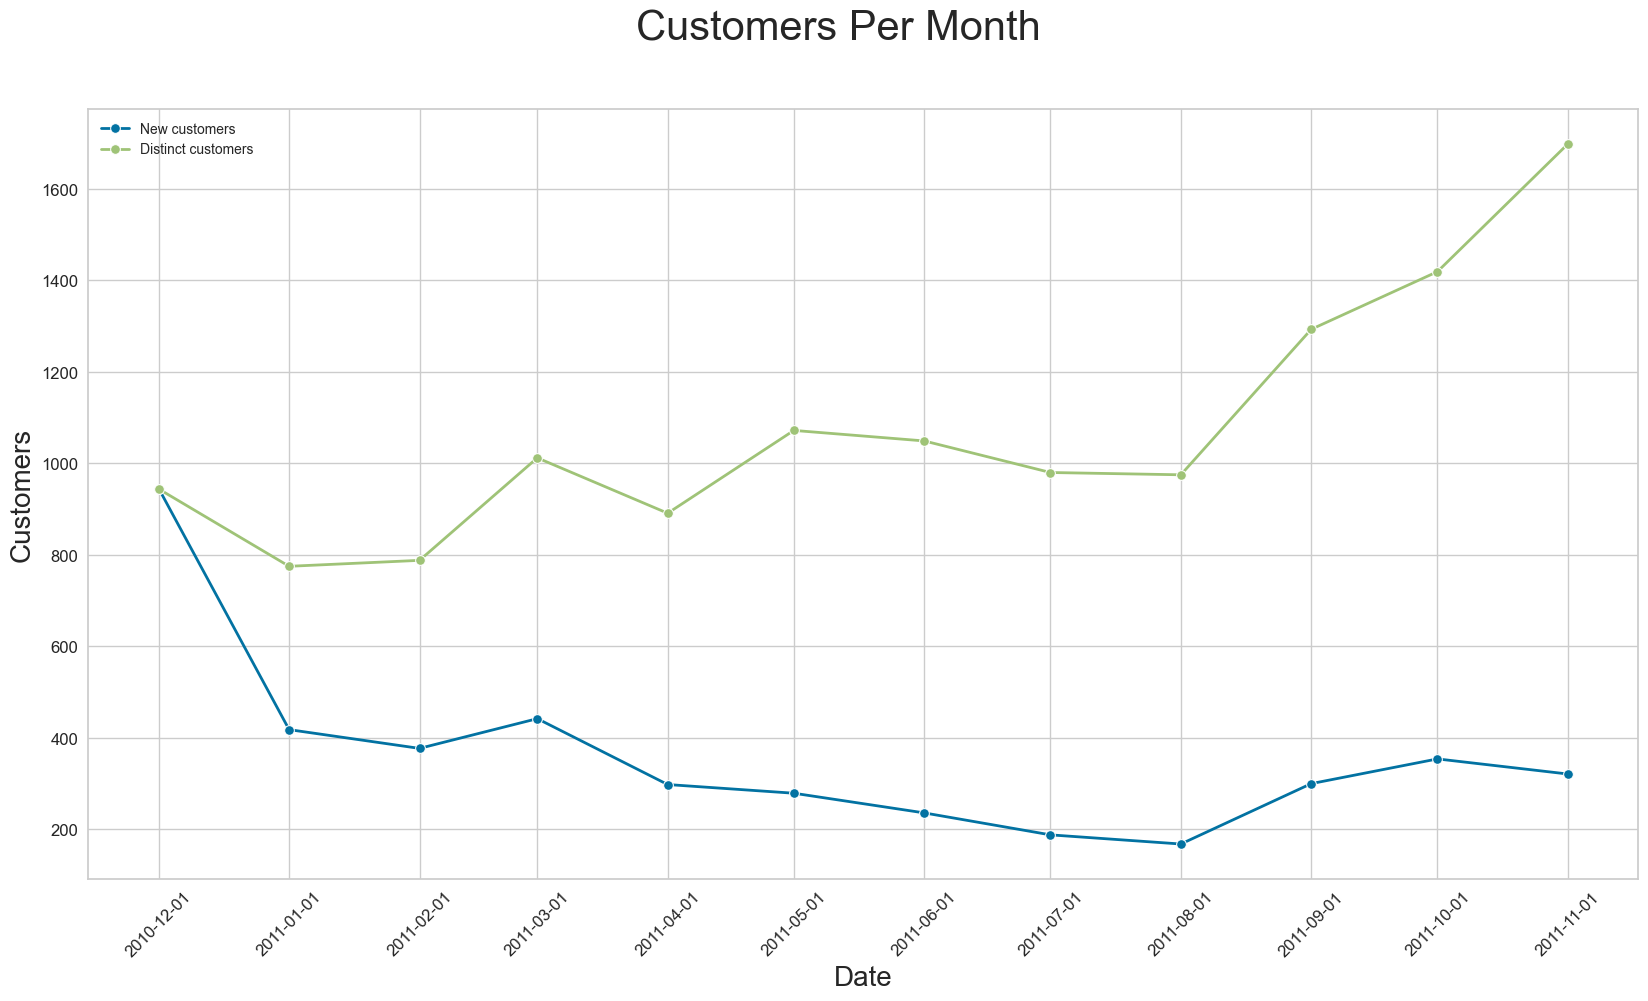

In [47]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Per Month', fontsize=30)
lineplot = sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2, label="New customers")
sns.lineplot(data=number_customers,x="Date", y="CustomerID", marker="o",linewidth = 2, label="Distinct customers")

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Customers",fontsize=20)
plt.xticks(dates,rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()



    📌 The number of new customers keeps decreasing probably due to the fact that we don't have enough historical data and some customers were already here before.

    However there is a real increase in customer acquisition on august 2011 probably due to a marketing campain targeting prospects. This probably explains the rise in the general sales trend studied above. But we can see that in august the customers curve increase more than the number of new customers: so previous customers have probably been also stimulated.



When do customers tend to purchase products?



In this part, I will try to understand if customers tend to purchase items in more particular time of the day.


In [48]:
df_temp = df.groupby([df.CustomerID,df.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()

In [49]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')

In [50]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(float(freq))
    row.append(month)
    count_hours.loc[len(count_hours)] = row
         
count_hours = count_hours.set_index("Month")    

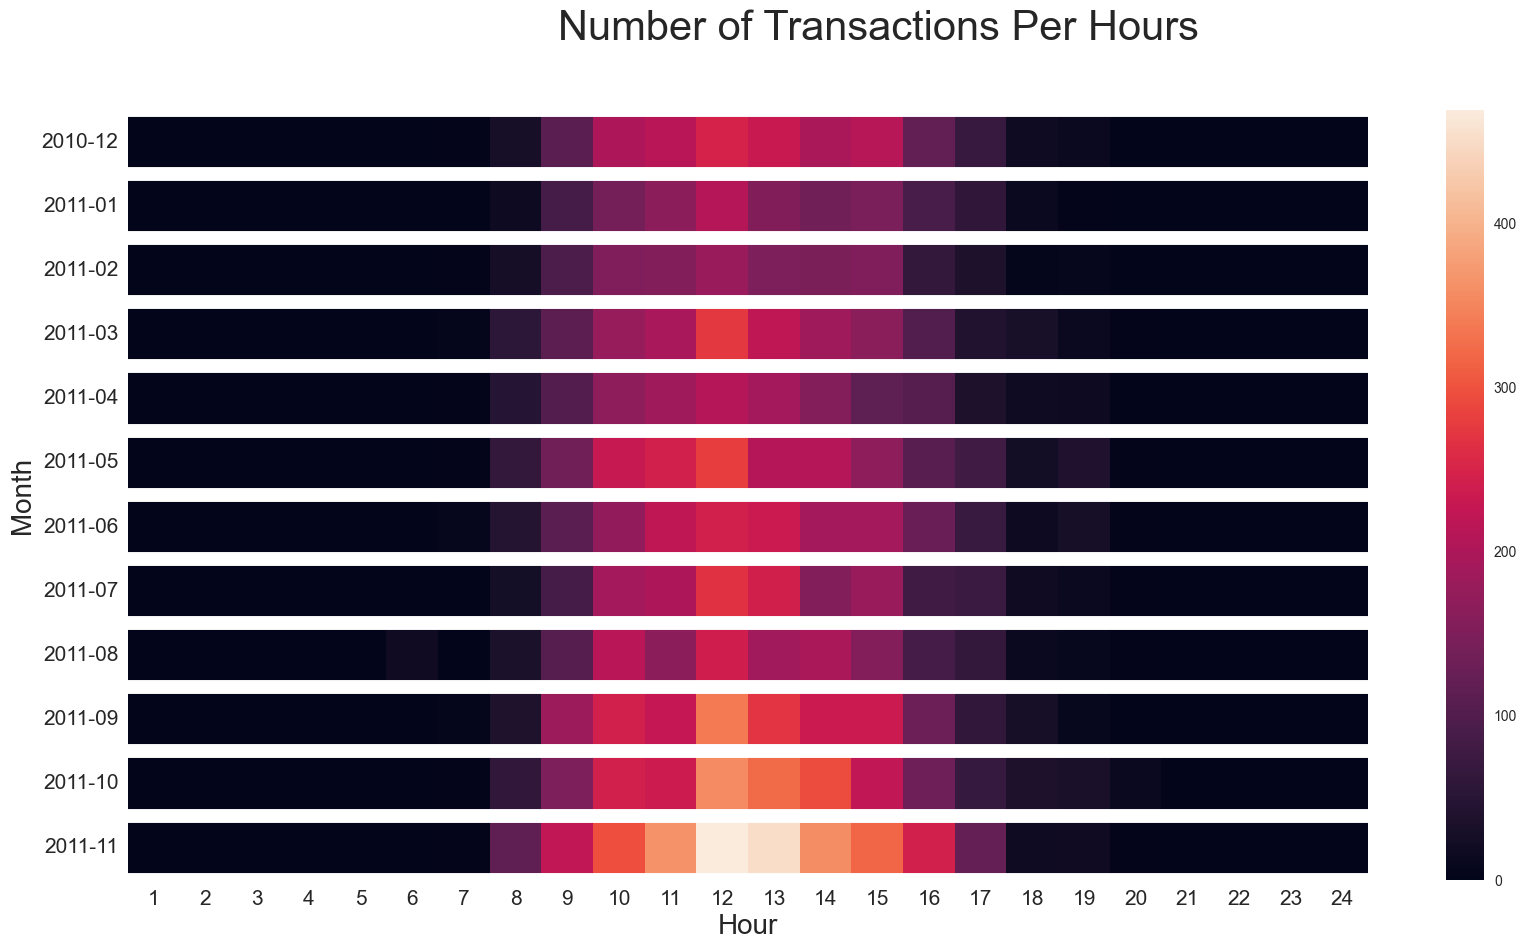

In [51]:


fig  = plt.figure(figsize = (20,10)).suptitle('Number of Transactions Per Hours', fontsize=30)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=10
               )

plt.show()



To describe the parts of the day, I used as a reference the Britannica Dictionary.

In [52]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 13):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return date.hour

df_temp['InvoiceDate'] = df_temp['InvoiceDate'].map(daytime_encoder)

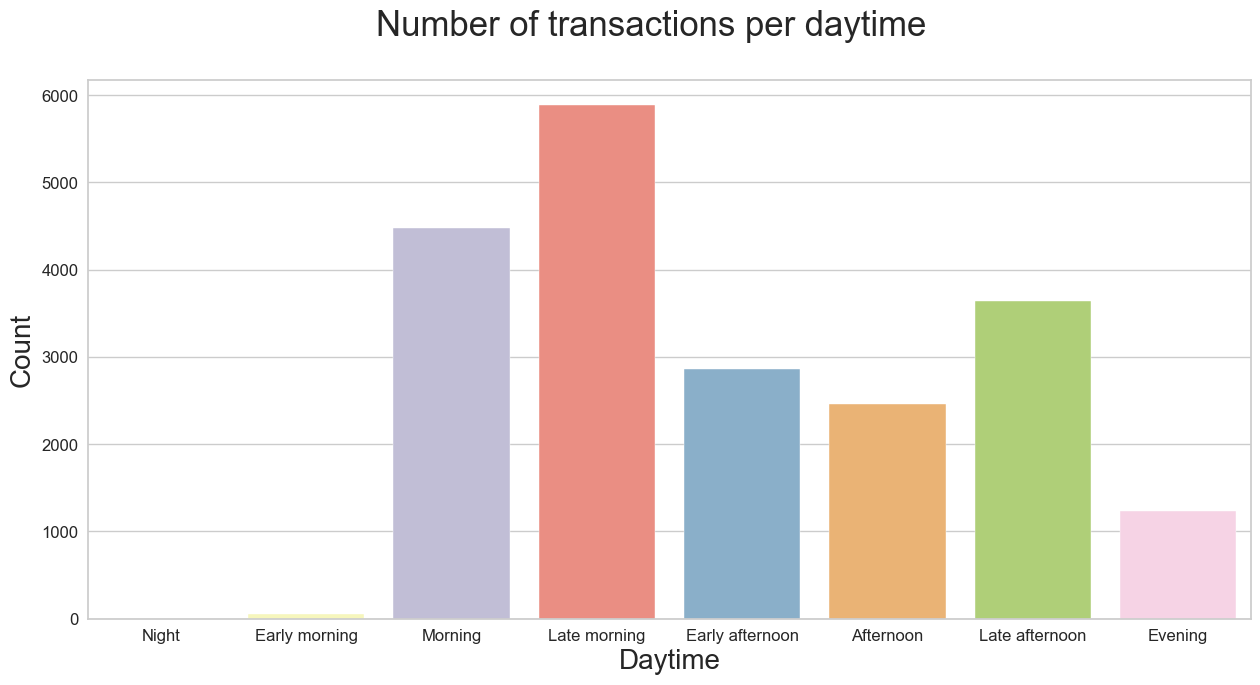

In [53]:
fig  = plt.figure(figsize = (15,7)).suptitle('Number of transactions per daytime', fontsize=25)
countplot = sns.countplot(data=df_temp,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

countplot.set_xlabel("Daytime",fontsize=20)
countplot.set_ylabel("Count",fontsize=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

📌 It seems that most of the transaction are made during late morning between 11am and 12am. On early morning though between 5am and 8am, there are not a lot of transactions made. And at night there are litterally no transactions at all.

# 3. RFM - Segmentation of the customers



RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

RFM analysis ranks each customer on the following factors:

    Recency. How recent was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours.

    Frequency. How often did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers.

    Monetary. How much money did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.


In [54]:
today_date = dt.datetime(2011, 12, 1)

In [55]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                     'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

In [56]:


#more days since last purchase 1 (very bad) ; those with fewer days 5 (very good).
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

#5 (very good) for those with high purchasing frequency; the ones that were less as 1 (very bad).
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#5 (very good) for those with a high purchase price;  the fewer purchase price as 1 (very bad).
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

#we'll not include monetory_score.
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))



In [57]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

CustomerID  recency  frequency  monetary recency_score frequency_score  \
0     12347.0       30          6   4085.18             4               4   
1     12348.0       66          4   1437.24             3               4   
2     12349.0        9          1   1457.55             5               1   
3     12350.0      301          1    294.40             1               1   
4     12352.0       27          8   1265.41             4               5   

  monetary_score RFM_SCORE          segment  
0              5        44  loyal_customers  
1              4        34  loyal_customers  
2              4        51    new_customers  
3              2        11      hibernating  
4              4        45  loyal_customers

In [58]:
segments_count = rfm.groupby("segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.head(15)

segment  count
0       about_to_sleep    361
1              at_Risk    612
2           cant_loose     80
3            champions    634
4          hibernating   1018
5      loyal_customers    797
6       need_attention    177
7        new_customers     66
8  potential_loyalists    474
9            promising     95

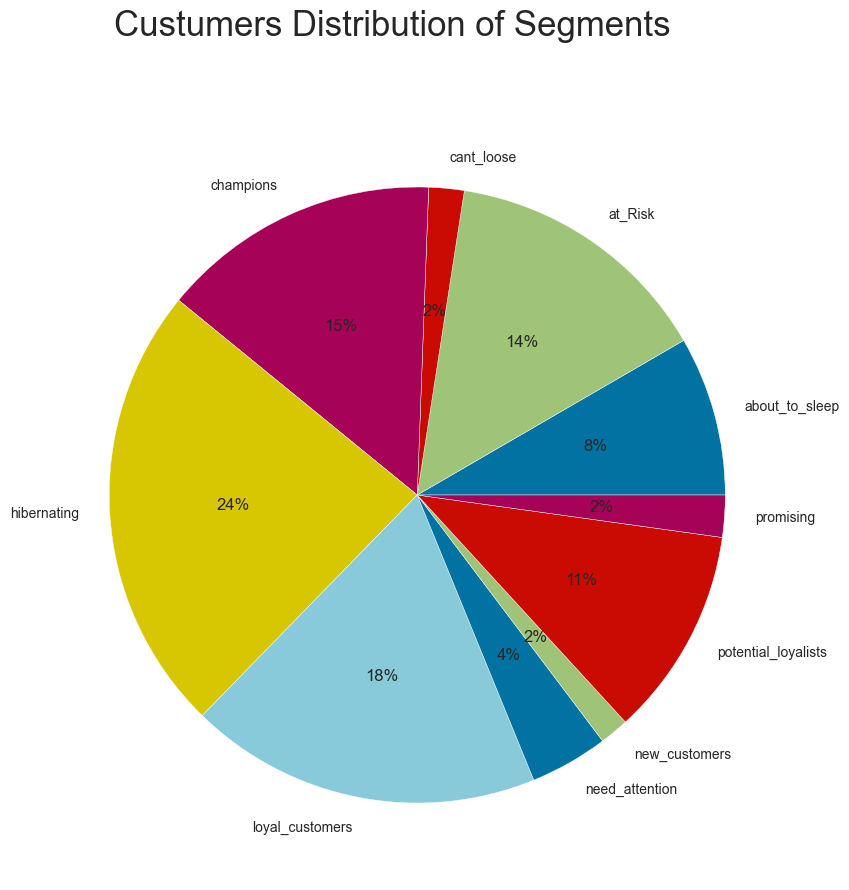

In [59]:
fig  = plt.figure(figsize = (20,10)).suptitle('Custumers Distribution of Segments', fontsize=25)
plt.pie(segments_count["count"], labels = segments_count["segment"], autopct='%.0f%%')

plt.show()

In [60]:


agg_list=["mean", "count", "max"]
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(agg_list)



recency             frequency                monetary  \
                           mean count  max       mean count  max         mean   
segment                                                                         
about_to_sleep        49.229917   361   68   1.243767   361    2   424.363521   
at_Risk              158.434641   612  363   3.155229   612    6   812.612583   
cant_loose           130.025000    80  303   8.962500    80   35  2227.118000   
champions              5.052050   634   12  13.246057   634  232  5048.993770   
hibernating          215.314342  1018  364   1.169941  1018    2   373.458684   
loyal_customers       31.190715   797   68   8.065245   797   65  2862.478471   
need_attention        47.977401   177   68   2.570621   177    3   784.676045   
new_customers          6.121212    66   12   1.000000    66    1   301.440758   
potential_loyalists   14.208861   474   30   2.099156   474    3   617.368903   
promising             20.747368    95   30   1.000000    95    1   357.926105   

                                      
                    count        max  
segment                               
about_to_sleep        361    4279.71  
at_Risk               612    6336.00  
cant_loose             80   11056.93  
champions             634  243207.14  
hibernating          1018    9338.38  
loyal_customers       797  101452.26  
need_attention        177    3683.86  
new_customers          66    1457.55  
potential_loyalists   474    3280.75  
promising              95    6207.67



    📌 Apparently there are 15% of customers considered as Champions. These customers are responsible for a big share of your revenue so we can put a lot of effort into keeping imroving their experience. What we can do:

        Give them something extra that the regulars do not get, for example, limited series of products or special discounts to make them feel valued.
        Use communication similar to the "Loyal" segment. For example making them ambassadors, giving them a margin of your profits for bringing you, new customers.
        Ask them for feedbacks as they might know the products and services very well.



# 4. Clustering - Segmentation of the customers

In [61]:
df_clustering = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : 'nunique',
                                     'TotalPrice' : 'sum'})

df_clustering.columns = ['recency', 'frequency', 'monetary']

After executing this code, the df_clustering DataFrame will contain the RFM metrics ('recency', 'frequency', and 'monetary') for each customer, which can be used for customer segmentation or clustering analysis. Each row in the DataFrame corresponds to a unique customer, and the columns represent their recency, frequency, and monetary behavior.

In [62]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index
df_scaled = df_scaled.set_index("CustomerID",drop=True)

After executing this code, the df_scaled DataFrame will contain the standardized RFM metrics ('recency', 'frequency', and 'monetary') for each customer, with 'CustomerID' as the index. Standardization makes it easier to compare the different RFM metrics on the same scale, which is often required for clustering algorithms or other statistical analyses.



To determine the optimal number of clusters, I will use the elbow method.


C:\Users\impra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\impra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\impra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\impra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

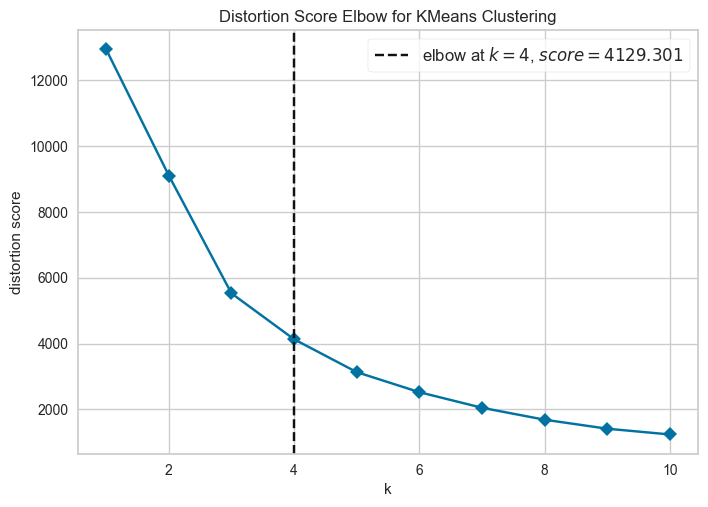

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)        
visualizer.show()        



When you run this code, you will see the elbow plot showing the distortion values for different k values. The optimal number of clusters is often determined by looking for the "elbow" point, where the distortion starts to level off. This point represents the number of clusters that balances the trade-off between fitting the data well (low distortion) and avoiding overfitting (too many clusters).

In [64]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

recency  frequency   monetary
0 -0.505254  -0.077718  -0.072624
1  1.510358  -0.346979  -0.209627
2 -0.861259  11.163562  14.164879
3 -0.781703   2.367451   1.406011

After executing this code, the centroid_df DataFrame will contain the coordinates of the four cluster centroids in the feature space. These centroids represent the average values of 'recency', 'frequency', and 'monetary' for each cluster and can be used to interpret and analyze the characteristics of the clusters.

In [65]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

After executing this code, the df_labels DataFrame will contain the cluster labels for each data point in the df_scaled DataFrame. Each row in df_labels corresponds to a data point, and the 'labels' column represents the cluster assignment for that data point. The cluster labels range from 0 to 3 (since n_clusters was set to 4 in the k-means model).

In [66]:
df_kmeans = df_clustering.copy()
df_kmeans['labels'] = df_labels['labels'].values

After executing this code, the df_kmeans DataFrame will contain the RFM metrics ('recency', 'frequency', and 'monetary') for each customer, along with an additional column 'labels', representing the cluster assignment obtained from k-means clustering. Each row in the DataFrame corresponds to a unique customer, and the 'labels' column indicates which cluster the customer belongs to based on their RFM metrics.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


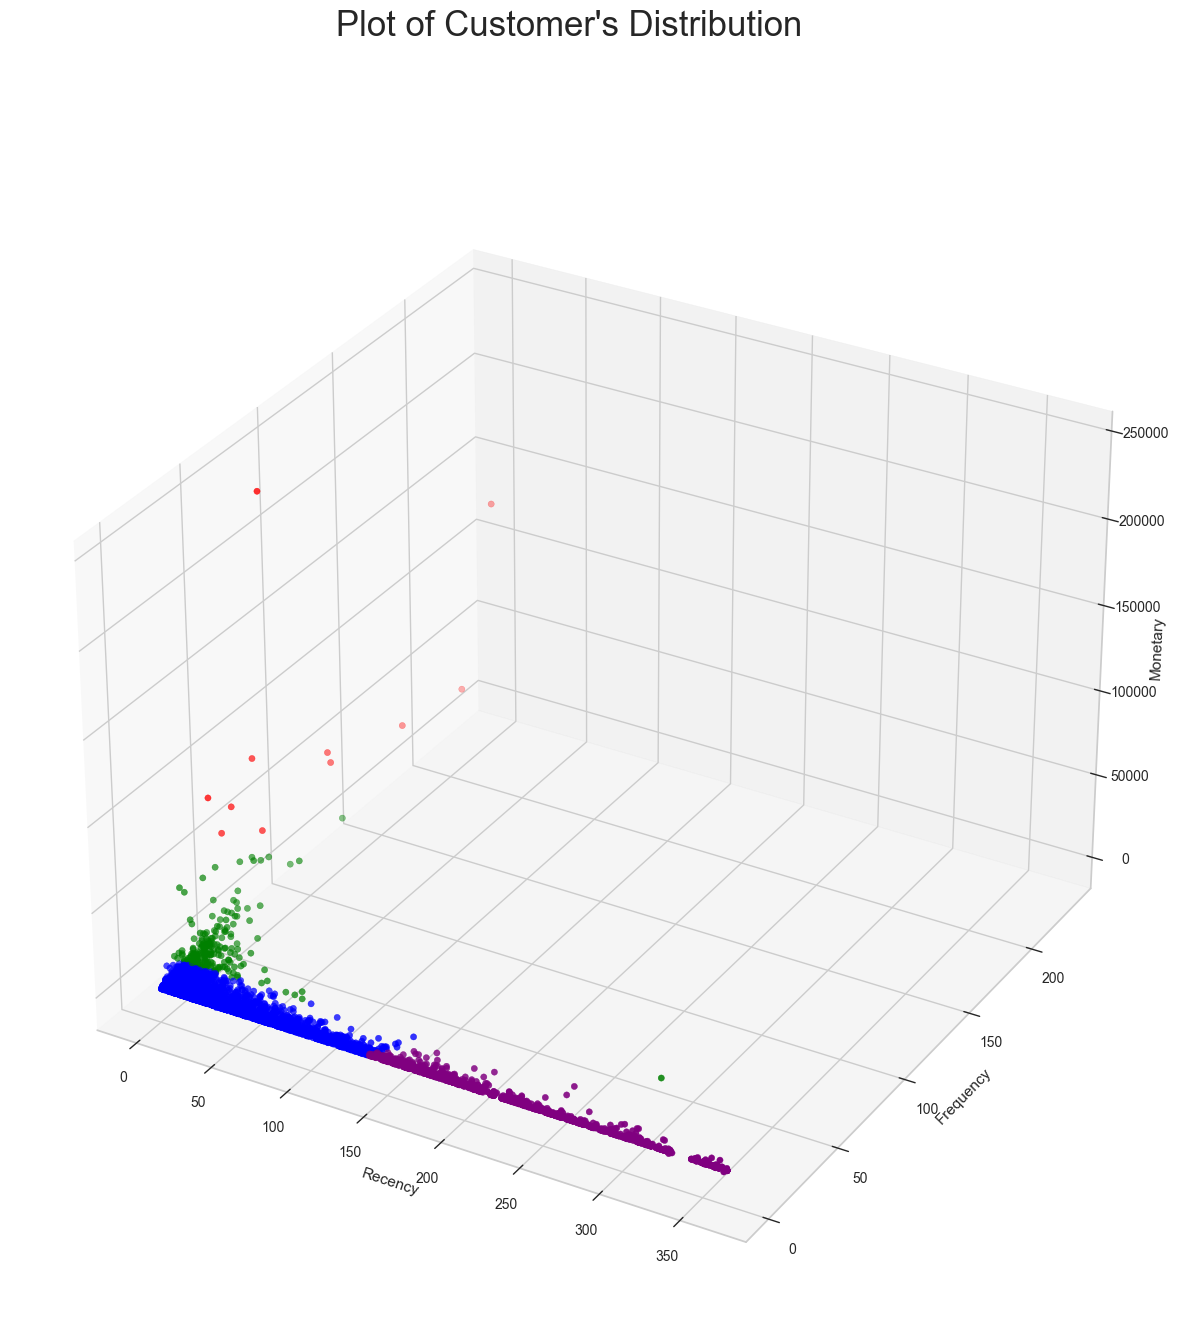

In [67]:
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('Plot of Customer\'s Distribution', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(df_kmeans["recency"], df_kmeans["frequency"], df_kmeans["monetary"], marker='o', c=colors[df_kmeans["labels"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

In [68]:
agg_list=["mean", "count", "max",]
df_kmeans[["labels", "recency", "frequency", "monetary"]].groupby("labels").agg(agg_list)

recency              frequency                 monetary        \
              mean count  max        mean count  max          mean count   
labels                                                                     
0        40.140845  2982  154    4.128102  2982   17   1234.838971  2982   
1       240.643885  1112  364    1.785971  1112   13    426.001314  1112   
2         4.727273    11   16  101.909091    11  232  85289.753636    11   
3        12.641148   209  293   25.397129   209  123   9964.353732   209   

                   
              max  
labels             
0        11056.93  
1         9338.38  
2       243207.14  
3        50415.49

This allows you to analyze and compare the characteristics of the different clusters based on these aggregated metrics.

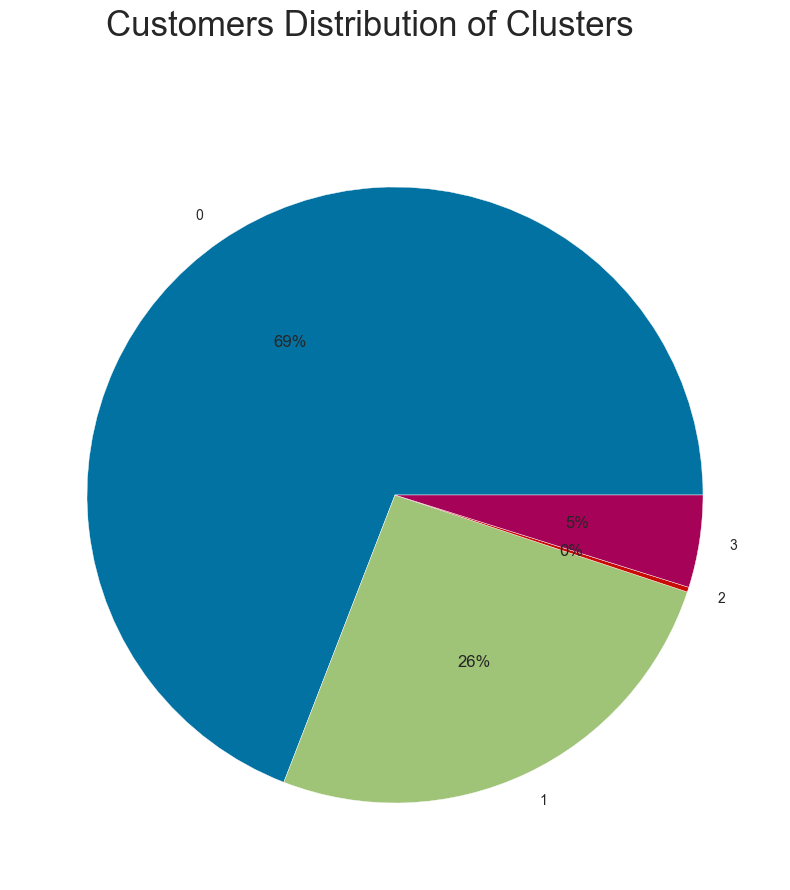

In [69]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters', fontsize=25)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')

plt.show()



    📌 From the KMeans clustering, we can sort every customer into 4 different clusters that seems to have different behaviours.

        Cluster 0: "Punctual customers" - Those are the customers that buys more punctually items on the website.
        Cluster 1: "Hibernating customers" - Those are the customers that buys at the lowest frequency, the lowest recently and that spend the least money.
        Cluster 2: "Exceptional customers" - Those are the customers that we want to keep, that buys at the highest frequency, the most recently and that spend the most money.
        Cluster 3: " Recent customers" - Those are customers that have been active quite recently that might be interesting to keep stimulated.

    The total distorsion score obtained is 4129 using the recency, the frequency and the monetary.



# Take away points

    1. The general sales trend seems to increase on august 2011, mainly due to the UK market. We can see a clear increase in the number of new customers during this month. However, some other countries such as France, Germany, Spain, Autralia and the Netherlands are quite active too.

    2. Some countries tend to have bigger average carts than other: Australia, Japan, Sweden and the Netherlands.

    3. There are differencies in the best-selling items based on the country. The best-selling item overall is the white hanging heart t-light holder.

    4. In average, a customer will come around 10 times on the website to buy items. But Ireland seem to have pretty active customers.

    5. Apparently the most active moment of the day is around noon, most of the customers purchase items during thios time of the day.

    6. Segmentation:

        RFM: Separated all the customers into 10 informative categories based on their recency, frequency and monetary.
        KMeans: Separated the customers into 4 groups that have similarities based on their recency, frequency and monetary. This time the categories are more flexible and not based on a grade.

    7. From the two segmentations we learnt that there are a few exceptional customers that we would want to keep offering them discounts, or an ambassador title. There is also a quarter of the customers that are not really active and don't spend a lot.
